In [203]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                           roc_auc_score, classification_report, confusion_matrix, roc_curve)
import xgboost as xgb
import pickle

categóricas originais
sex ticket cabin embarked pclass (ordinal)

numéricas originais
age
sibsp
parch
fare

In [204]:
df = pd.read_csv('train.csv')
print(f"Shape do dataset: {df.shape}")

Shape do dataset: (891, 12)


| Variable  | Definition                                   | Key                                      |
|-----------|----------------------------------------------|------------------------------------------|
| survival  | Survival                                     | 0 = No, 1 = Yes                          |
| pclass    | Ticket class                                 | 1 = 1st, 2 = 2nd, 3 = 3rd                |
| sex       | Sex                                          |                                          |
| Age       | Age in years                                 |                                          |
| sibsp     | # of siblings / spouses aboard the Titanic   |                                          |
| parch     | # of parents / children aboard the Titanic   |                                          |
| ticket    | Ticket number                                |                                          |
| fare      | Passenger fare                               |                                          |
| cabin     | Cabin number                                 |                                          |
| embarked  | Port of Embarkation                          | C = Cherbourg, Q = Queenstown, S = Southampton |


In [205]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Análise Exploratória de Dados

### Verificação de valores ausentes

In [206]:
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100

missing_df = pd.DataFrame({
    'Coluna': missing_data.index,
    'Valores Ausentes': missing_data.values,
    'Percentual (%)': missing_percent.values
}).sort_values('Valores Ausentes', ascending=False)

display(missing_df[missing_df['Valores Ausentes'] > 0])

,Coluna,Valores Ausentes,Percentual (%)
10,Cabin,687,77.104377
5,Age,177,19.865320
11,Embarked,2,0.224467


### Distribuição da Target

Contagem:
Survived
0    549
1    342
Name: count, dtype: int64

Percentual:
Survived
0    61.616162
1    38.383838
Name: proportion, dtype: float64


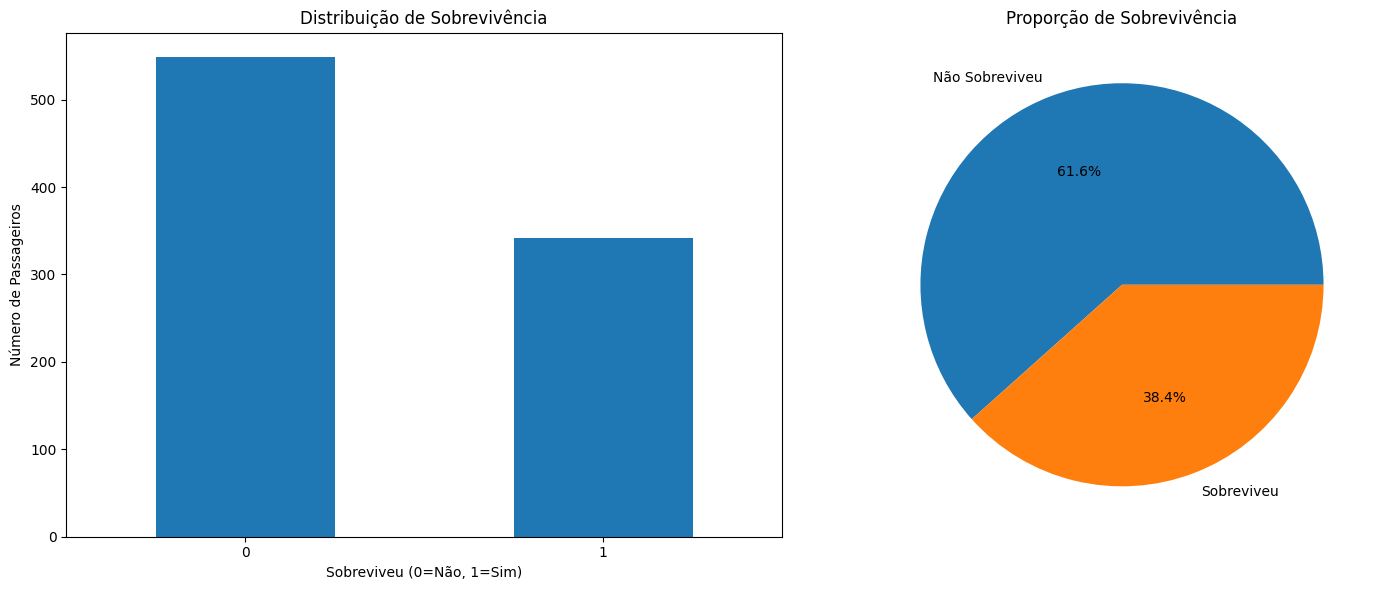

In [207]:
survival_counts = df['Survived'].value_counts()
survival_percent = df['Survived'].value_counts(normalize=True) * 100

print("Contagem:")
print(survival_counts)
print("\nPercentual:")
print(survival_percent)

# Visualização
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico de barras
survival_counts.plot(kind='bar', ax=ax1)
ax1.set_title('Distribuição de Sobrevivência')
ax1.set_xlabel('Sobreviveu (0=Não, 1=Sim)')
ax1.set_ylabel('Número de Passageiros')
ax1.tick_params(axis='x', rotation=0)

# Gráfico de pizza
ax2.pie(survival_counts.values, labels=['Não Sobreviveu', 'Sobreviveu'], 
        autopct='%1.1f%%')
ax2.set_title('Proporção de Sobrevivência')

plt.tight_layout()
plt.show()

### Variáveis Categóricas

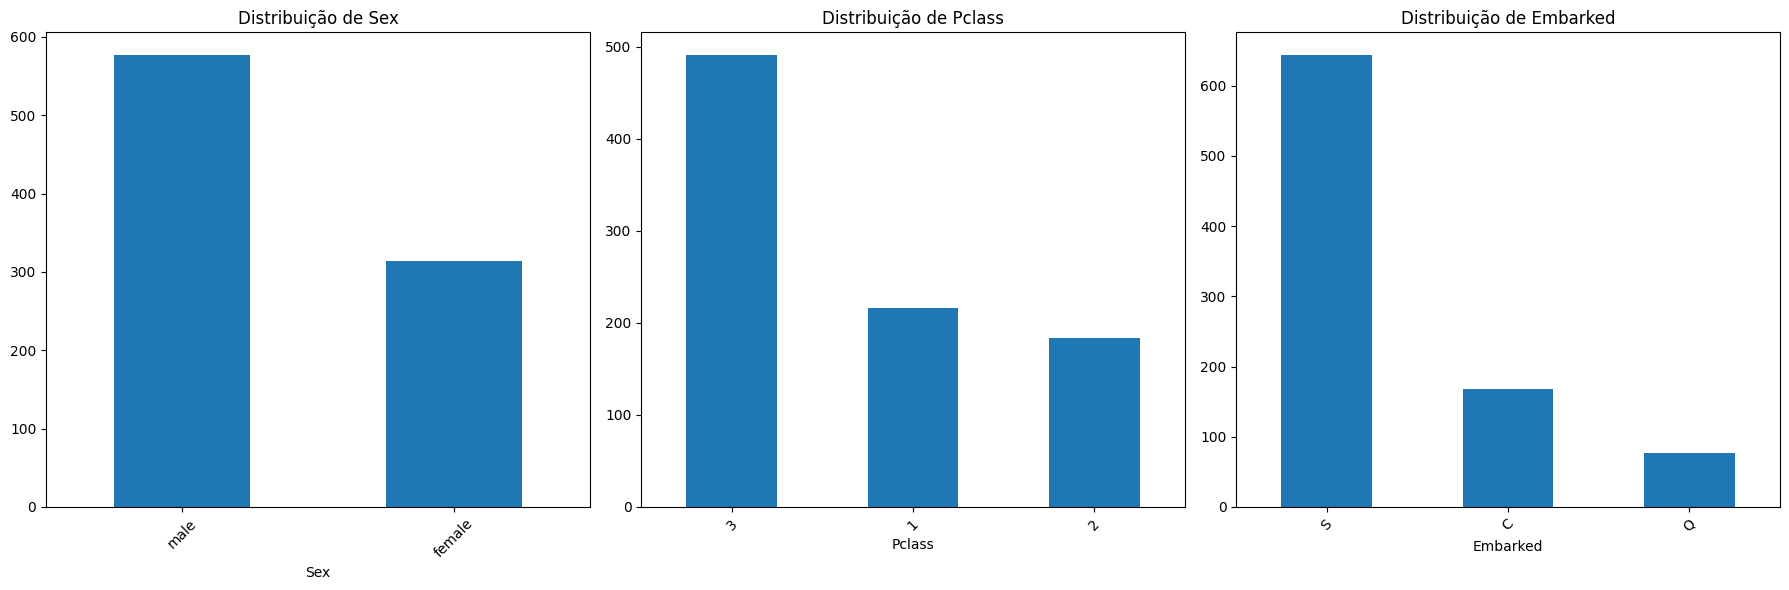

In [208]:
categorical_vars = ['Sex', 'Pclass', 'Embarked', 'Name', 'Cabin', 'Ticket']
vars_to_plot = [var for var in categorical_vars if var not in ['Name', 'Cabin', 'Ticket']]

fig, axes = plt.subplots(1, len(vars_to_plot), figsize=(6 * len(vars_to_plot), 6))
axes = axes.ravel()

for i, var in enumerate(vars_to_plot):
    if var in df.columns:
        df[var].value_counts().plot(kind='bar', ax=axes[i])
        axes[i].set_title(f'Distribuição de {var.title()}')
        axes[i].tick_params(axis='x', rotation=45)
    else:
        axes[i].text(0.5, 0.5, f'{var} não encontrada', ha='center', va='center')
        axes[i].set_title(f'{var.title()} - Não Disponível')

plt.tight_layout()
plt.show()

### Variáveis Numéricas

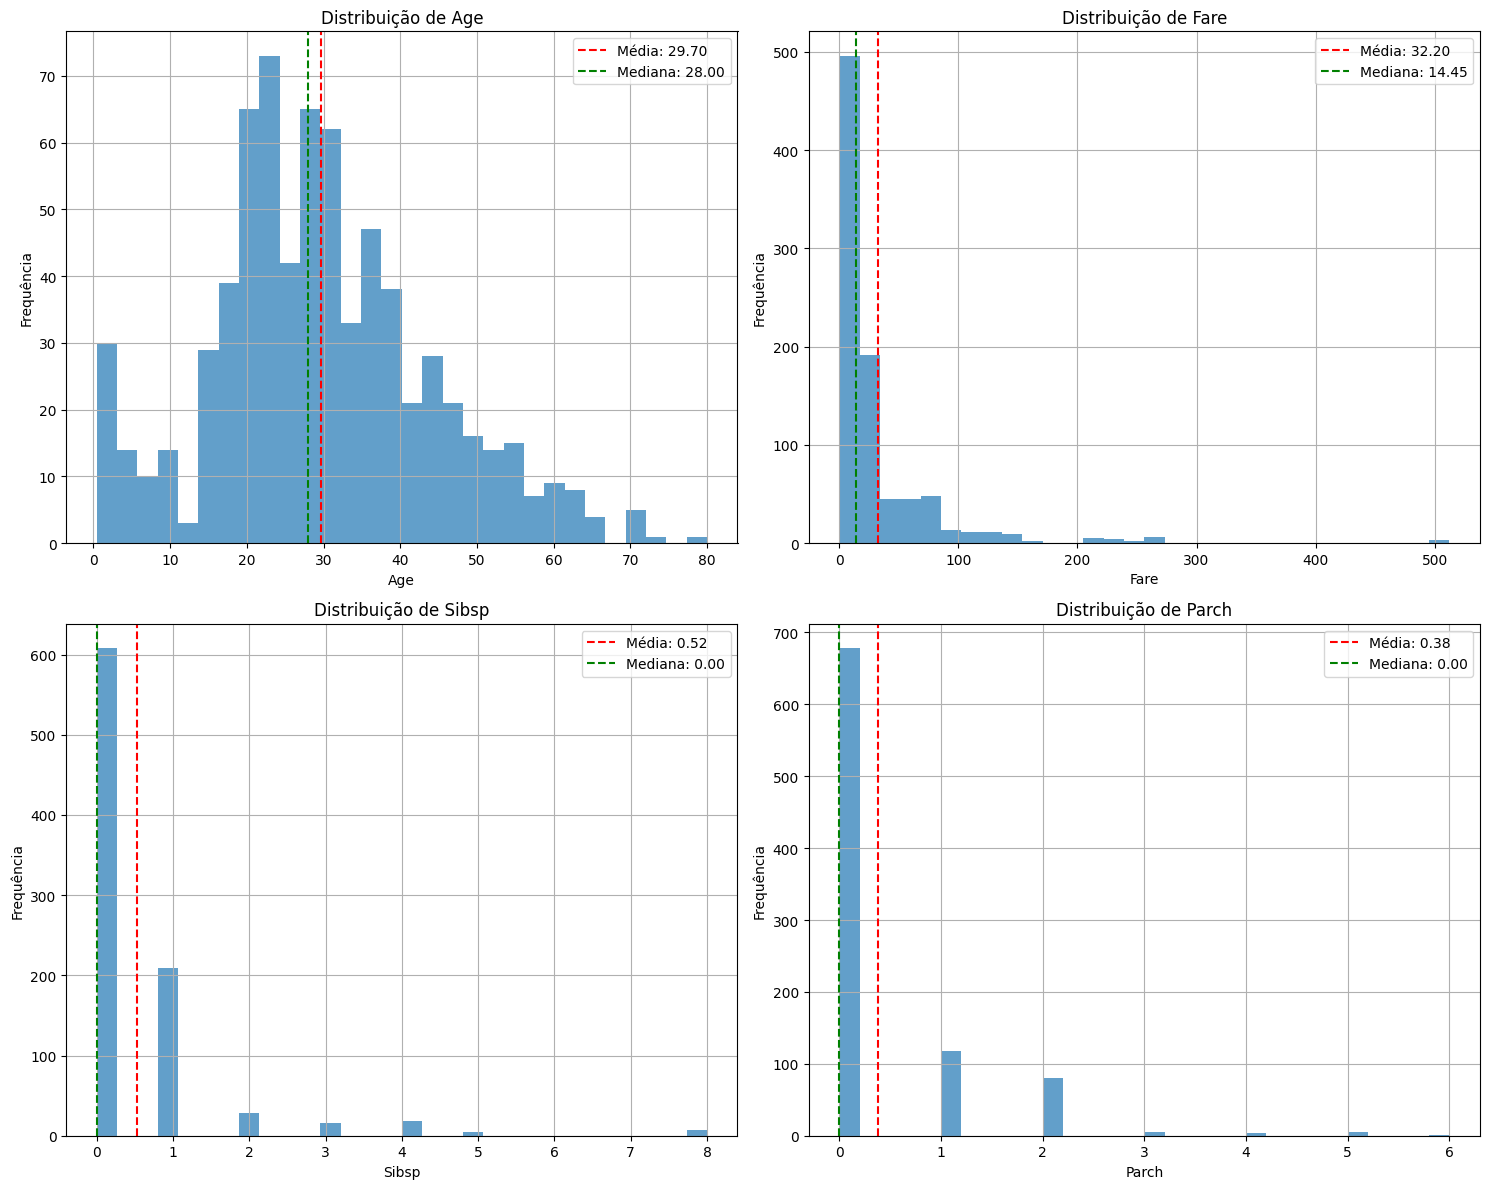

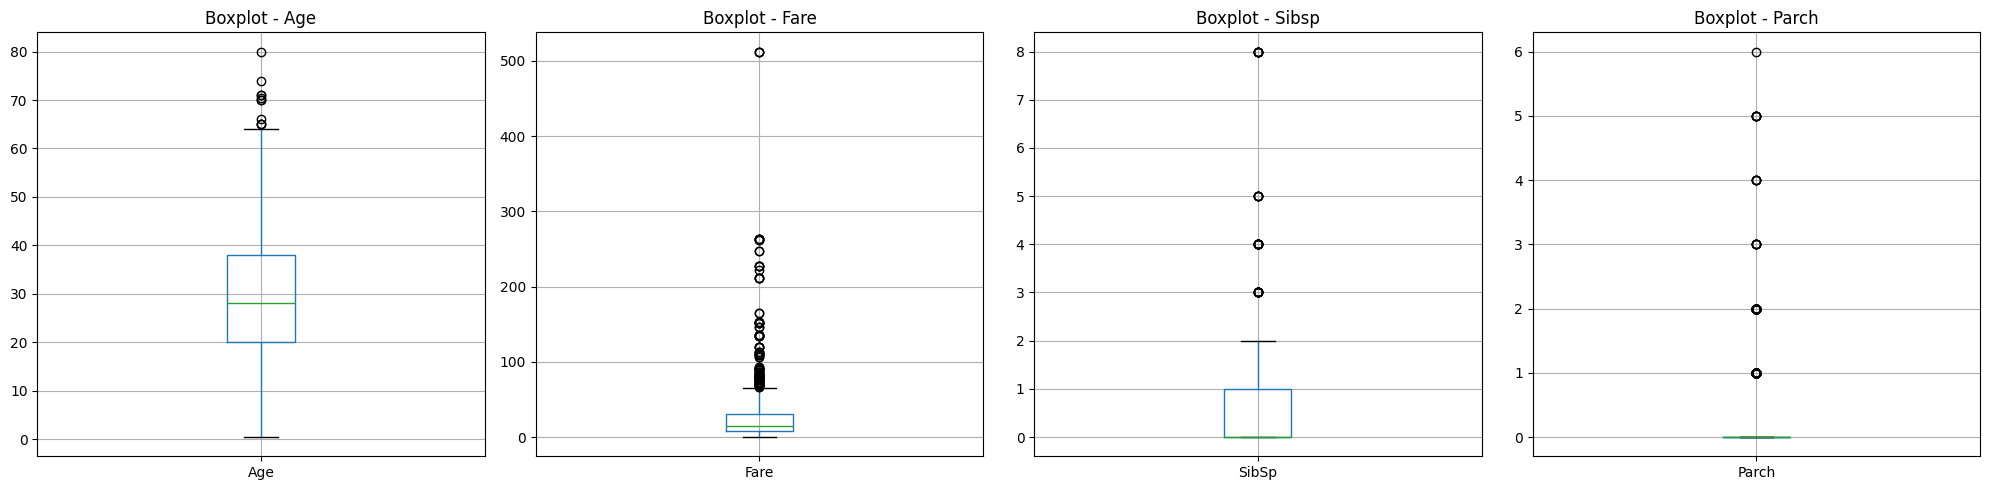

In [209]:
numerical_vars = ['Age', 'Fare', 'SibSp', 'Parch']

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, var in enumerate(numerical_vars):
    if var in df.columns:
        # Histograma
        df[var].hist(bins=30, ax=axes[i], alpha=0.7)
        axes[i].set_title(f'Distribuição de {var.title()}')
        axes[i].set_xlabel(var.title())
        axes[i].set_ylabel('Frequência')
        
        # Adicionar estatísticas
        mean_val = df[var].mean()
        median_val = df[var].median()
        axes[i].axvline(mean_val, color='red', linestyle='--', label=f'Média: {mean_val:.2f}')
        axes[i].axvline(median_val, color='green', linestyle='--', label=f'Mediana: {median_val:.2f}')
        axes[i].legend()

plt.tight_layout()
plt.show()

# Boxplots para identificar outliers
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i, var in enumerate(numerical_vars):
    if var in df.columns:
        df.boxplot(column=var, ax=axes[i])
        axes[i].set_title(f'Boxplot - {var.title()}')

plt.tight_layout()
plt.show()

### Sobrevivência por Gênero

Contagem:


Survived,0,1
Sex,,
female,81,233
male,468,109



Percentual:


Survived,0,1
Sex,,
female,25.796178,74.203822
male,81.109185,18.890815


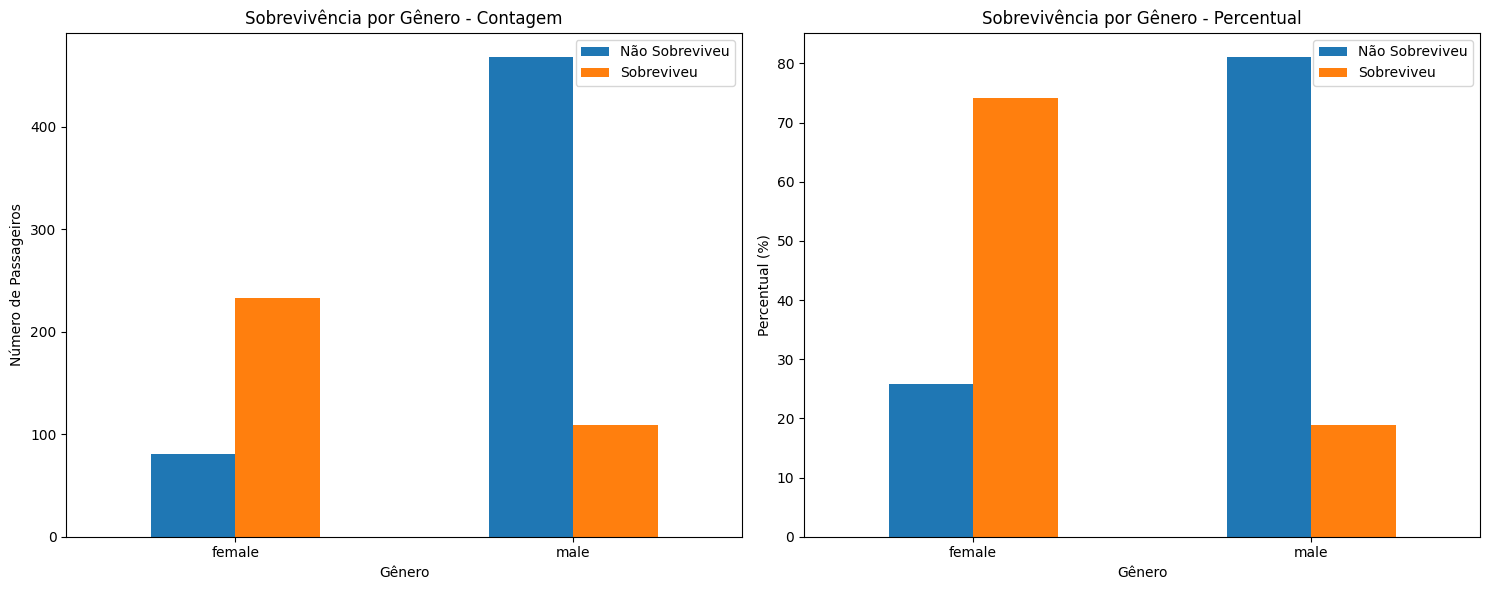

In [210]:
gender_survival = pd.crosstab(df['Sex'], df['Survived'])
gender_survival_pct = pd.crosstab(df['Sex'], df['Survived'], normalize='index') * 100

print("Contagem:")
display(gender_survival)
print("\nPercentual:")
display(gender_survival_pct)

# Visualização
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico de barras agrupadas
gender_survival.plot(kind='bar', ax=ax1)
ax1.set_title('Sobrevivência por Gênero - Contagem')
ax1.set_xlabel('Gênero')
ax1.set_ylabel('Número de Passageiros')
ax1.legend(['Não Sobreviveu', 'Sobreviveu'])
ax1.tick_params(axis='x', rotation=0)

# Gráfico de barras percentual
gender_survival_pct.plot(kind='bar', ax=ax2)
ax2.set_title('Sobrevivência por Gênero - Percentual')
ax2.set_xlabel('Gênero')
ax2.set_ylabel('Percentual (%)')
ax2.legend(['Não Sobreviveu', 'Sobreviveu'])
ax2.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

### Sobrevivência por classe

Contagem:


Survived,0,1
Pclass,,
1,80,136
2,97,87
3,372,119



Percentual:


Survived,0,1
Pclass,,
1,37.037037,62.962963
2,52.717391,47.282609
3,75.763747,24.236253


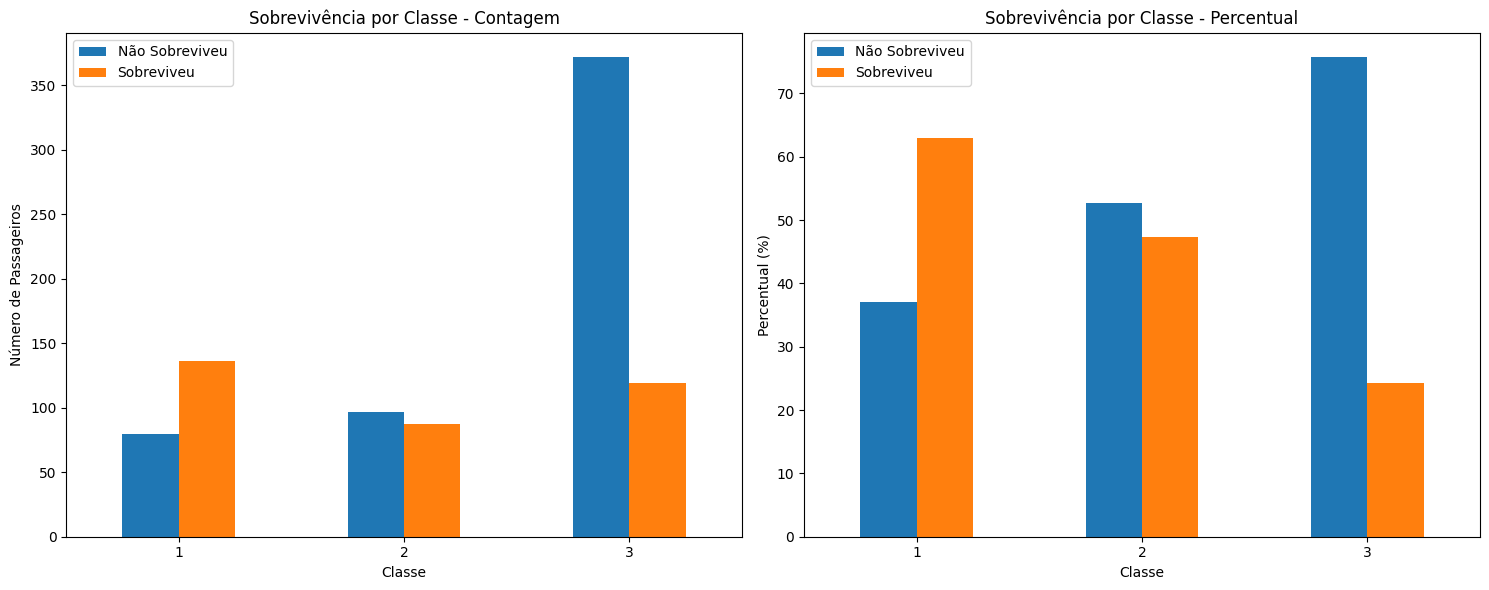

In [211]:
class_survival = pd.crosstab(df['Pclass'], df['Survived'])
class_survival_pct = pd.crosstab(df['Pclass'], df['Survived'], normalize='index') * 100

print("Contagem:")
display(class_survival)
print("\nPercentual:")
display(class_survival_pct)

# Visualização
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

class_survival.plot(kind='bar', ax=ax1)
ax1.set_title('Sobrevivência por Classe - Contagem')
ax1.set_xlabel('Classe')
ax1.set_ylabel('Número de Passageiros')
ax1.legend(['Não Sobreviveu', 'Sobreviveu'])
ax1.tick_params(axis='x', rotation=0)

class_survival_pct.plot(kind='bar', ax=ax2)
ax2.set_title('Sobrevivência por Classe - Percentual')
ax2.set_xlabel('Classe')
ax2.set_ylabel('Percentual (%)')
ax2.legend(['Não Sobreviveu', 'Sobreviveu'])
ax2.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

### Sobrevivência por idade

Percentual por grupo etário:


Survived,0,1
Age_Group,,
Child,42.028986,57.971014
Teenager,57.142857,42.857143
Young,61.731844,38.268156
Adult,60.000000,40.000000
Elderly,77.272727,22.727273


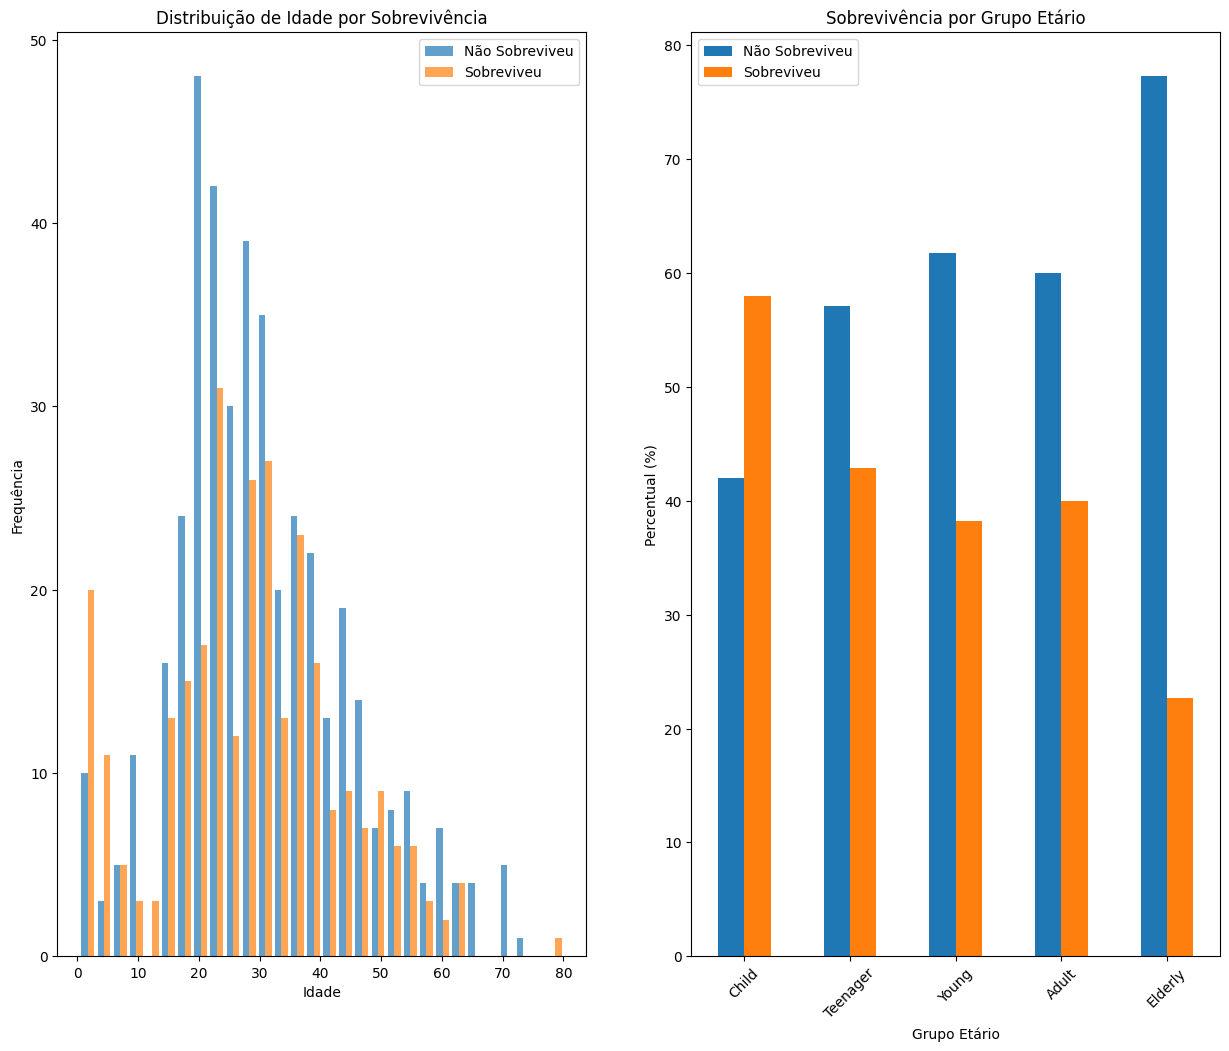

In [212]:
df['Age_Group'] = pd.cut(df['Age'], 
                        bins=[0, 12, 18, 35, 60, 100], 
                        labels=['Child', 'Teenager', 
                               'Young', 'Adult', 'Elderly'])

age_survival = pd.crosstab(df['Age_Group'], df['Survived'])
age_survival_pct = pd.crosstab(df['Age_Group'], df['Survived'], normalize='index') * 100

print("Percentual por grupo etário:")
display(age_survival_pct)

fig, axes = plt.subplots(1, 2, figsize=(15, 12))

axes[0].hist([df[df['Survived']==0]['Age'].dropna(), 
                df[df['Survived']==1]['Age'].dropna()], 
               bins=30, alpha=0.7, label=['Não Sobreviveu', 'Sobreviveu'])
axes[0].set_title('Distribuição de Idade por Sobrevivência')
axes[0].set_xlabel('Idade')
axes[0].set_ylabel('Frequência')
axes[0].legend()


age_survival_pct.plot(kind='bar', ax=axes[1])
axes[1].set_title('Sobrevivência por Grupo Etário')
axes[1].set_xlabel('Grupo Etário')
axes[1].set_ylabel('Percentual (%)')
axes[1].legend(['Não Sobreviveu', 'Sobreviveu'])
axes[1].tick_params(axis='x', rotation=45)

plt.show()

### Principais Fatores de Sobrevivência:

Gênero: As mulheres tiveram uma taxa de sobrevivência significativamente maior que os homens

Classe Social: Passageiros da primeira classe tiveram maior probabilidade de sobrevivência

Idade: Crianças tiveram maiores chances de sobrevivência

Política "Mulheres e Crianças Primeiro": Claramente implementada durante o desastre

---
## Fim da Análise Exploratória de Dados (EDA)
---
## Início do Feature Engineering
Nesta seção, serão realizadas as transformações e criações de novas variáveis para melhorar a performance dos modelos de machine learning.

# Feature Engineering

In [213]:
df = pd.read_csv('train.csv')
categorical_vars = ['Sex', 'Pclass', 'Embarked', 'Name', 'Cabin', 'Ticket']
numerical_vars = ['Age', 'Fare', 'SibSp', 'Parch']
target = 'Survived'

In [214]:
print(f"Colunas Totais: {df.columns.values}")
print(f"Variáveis categóricas: {categorical_vars}")
print(f"Variáveis numéricas: {numerical_vars}")

Colunas Totais: ['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']
Variáveis categóricas: ['Sex', 'Pclass', 'Embarked', 'Name', 'Cabin', 'Ticket']
Variáveis numéricas: ['Age', 'Fare', 'SibSp', 'Parch']


Title
Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Mlle          2
Major         2
Ms            1
Mme           1
Don           1
Lady          1
Sir           1
Capt          1
Countess      1
Jonkheer      1
Name: count, dtype: int64


<>:5: SyntaxWarning: invalid escape sequence '\.'
<>:5: SyntaxWarning: invalid escape sequence '\.'
C:\Users\vinic\AppData\Local\Temp\ipykernel_22748\3077789341.py:5: SyntaxWarning: invalid escape sequence '\.'
  title_search = re.search(' ([A-Za-z]+)\.', name)


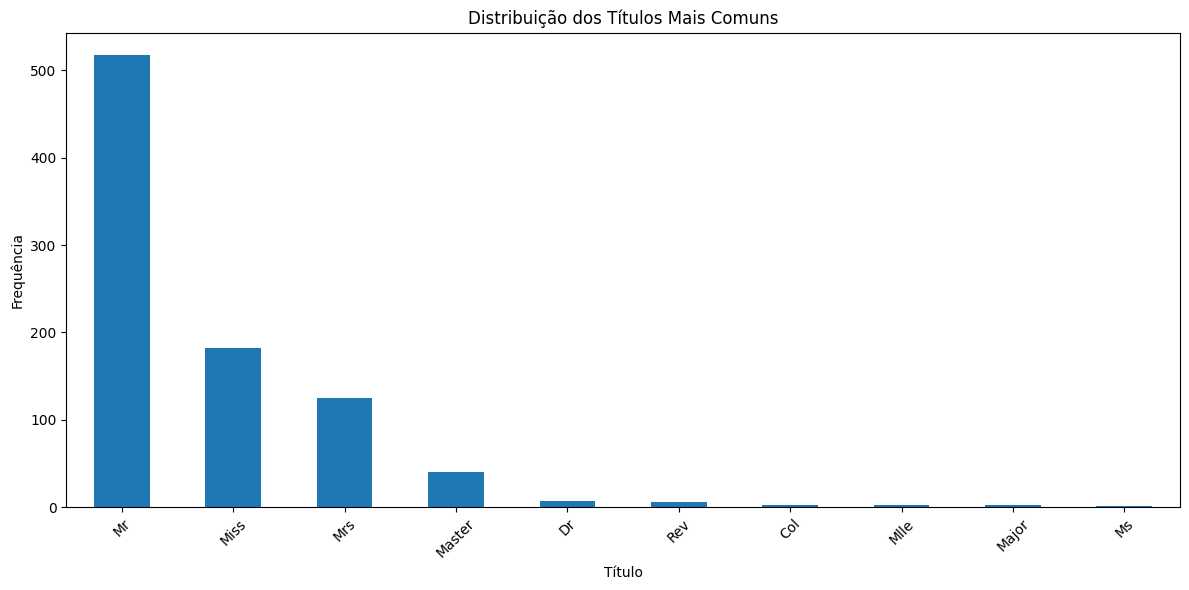

In [215]:
import re

def extract_title(name):
    """Extrai título do nome do passageiro"""
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

# Aplicar extração de título
df['Title'] = df['Name'].apply(extract_title)

print(df['Title'].value_counts())

# Visualizar distribuição de títulos
plt.figure(figsize=(12, 6))
df['Title'].value_counts().head(10).plot(kind='bar')
plt.title('Distribuição dos Títulos Mais Comuns')
plt.xlabel('Título')
plt.ylabel('Frequência')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Title_Mapped
Mr        517
Miss      184
Mrs       126
Master     40
Rare       24
Name: count, dtype: int64
Title_Mapped
Mrs       0.793651
Miss      0.701087
Master    0.575000
Rare      0.375000
Mr        0.156673
Name: Survived, dtype: float64


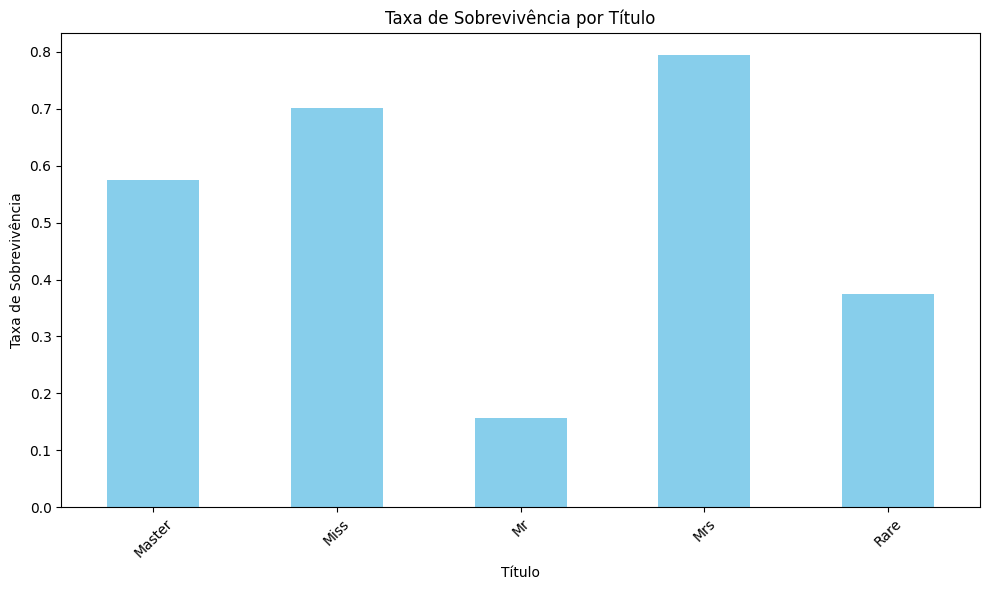

In [216]:
def map_title(title):
    """Mapeia títulos para categorias mais gerais"""
    title_mapping = {
        "Mr": "Mr",
        "Miss": "Miss", 
        "Mrs": "Mrs",
        "Master": "Master",
        "Dr": "Rare",
        "Rev": "Rare",
        "Mlle": "Miss",
        "Major": "Rare", 
        "Col": "Rare",
        "Sir": "Rare",
        "Mme": "Mrs",
        "Don": "Rare",
        "Lady": "Rare",
        "Countess": "Rare",
        "Jonkheer": "Rare",
        "Dona": "Rare",
        "Capt": "Rare"
    }
    return title_mapping.get(title, "Rare")

# Aplicar mapeamento
df['Title_Mapped'] = df['Title'].apply(map_title)

print(df['Title_Mapped'].value_counts())

# Visualizar sobrevivência por título
survival_by_title = df.groupby('Title_Mapped')['Survived'].mean()
print(survival_by_title.sort_values(ascending=False))

# Gráfico
plt.figure(figsize=(10, 6))
survival_by_title.plot(kind='bar', color='skyblue')
plt.title('Taxa de Sobrevivência por Título')
plt.xlabel('Título')
plt.ylabel('Taxa de Sobrevivência')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

=== DISTRIBUIÇÃO POR DECK ===
Deck
Unknown    687
C           59
B           47
D           33
E           32
A           15
F           13
G            4
T            1
Name: count, dtype: int64

=== DISTRIBUIÇÃO DE NÚMERO DE CABINES ===
Cabin_Count
0    687
1    180
2     16
3      6
4      2
Name: count, dtype: int64


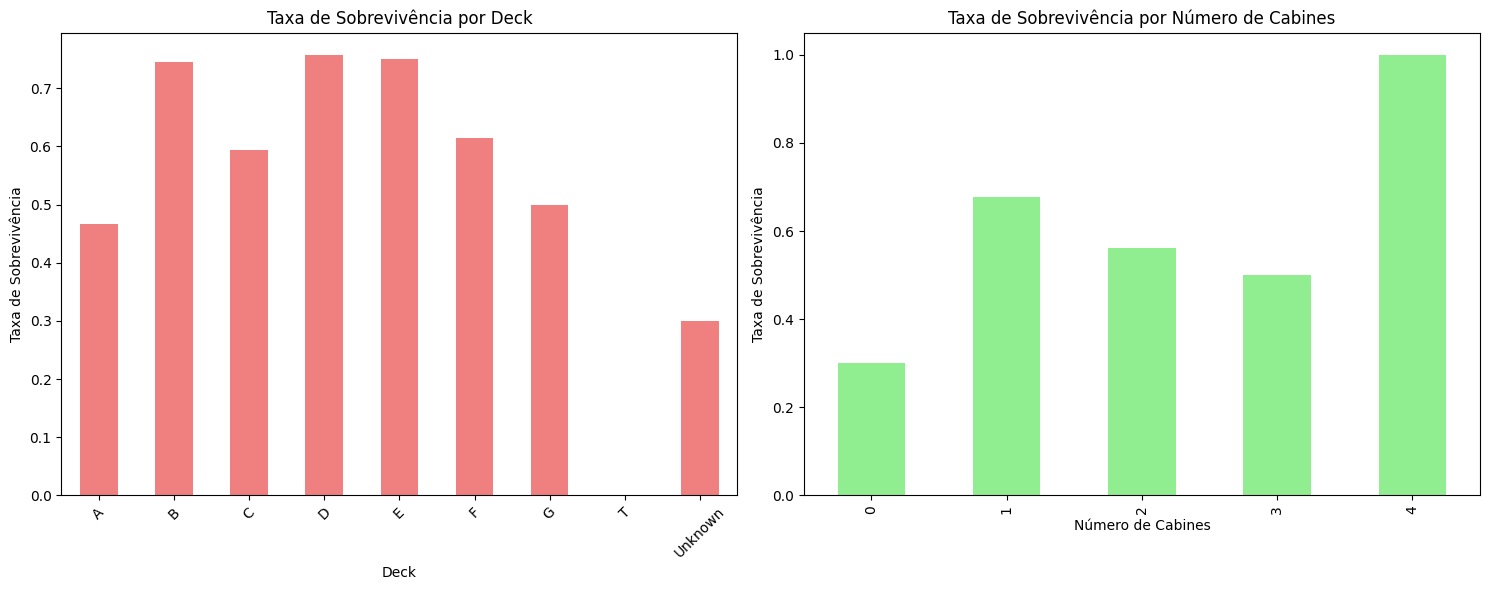

In [217]:
def extract_deck(cabin):
    """Extrai o deck da cabine"""
    if pd.isna(cabin):
        return 'Unknown'
    return cabin[0]

# Função para contar cabines
def count_cabins(cabin):
    """Conta quantas cabines o passageiro possui"""
    if pd.isna(cabin):
        return 0
    return len(cabin.split())

# Aplicar extração de deck e contagem de cabines
df['Deck'] = df['Cabin'].apply(extract_deck)
df['Cabin_Count'] = df['Cabin'].apply(count_cabins)

print("=== DISTRIBUIÇÃO POR DECK ===")
print(df['Deck'].value_counts())

print("\n=== DISTRIBUIÇÃO DE NÚMERO DE CABINES ===")
print(df['Cabin_Count'].value_counts())

# Visualizar sobrevivência por deck
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Sobrevivência por deck
survival_by_deck = df.groupby('Deck')['Survived'].mean()
survival_by_deck.plot(kind='bar', ax=axes[0], color='lightcoral')
axes[0].set_title('Taxa de Sobrevivência por Deck')
axes[0].set_xlabel('Deck')
axes[0].set_ylabel('Taxa de Sobrevivência')
axes[0].tick_params(axis='x', rotation=45)

# Sobrevivência por número de cabines
survival_by_cabin_count = df.groupby('Cabin_Count')['Survived'].mean()
survival_by_cabin_count.plot(kind='bar', ax=axes[1], color='lightgreen')
axes[1].set_title('Taxa de Sobrevivência por Número de Cabines')
axes[1].set_xlabel('Número de Cabines')
axes[1].set_ylabel('Taxa de Sobrevivência')

plt.tight_layout()
plt.show()

Ticket_Prefix
Numeric    661
PC          60
C           33
A           29
STON        18
SOTON       17
CA          14
S           14
SC          13
W           11
Name: count, dtype: int64
Ticket_Group_Size
1    547
2    188
3     63
4     44
7     21
Name: count, dtype: int64


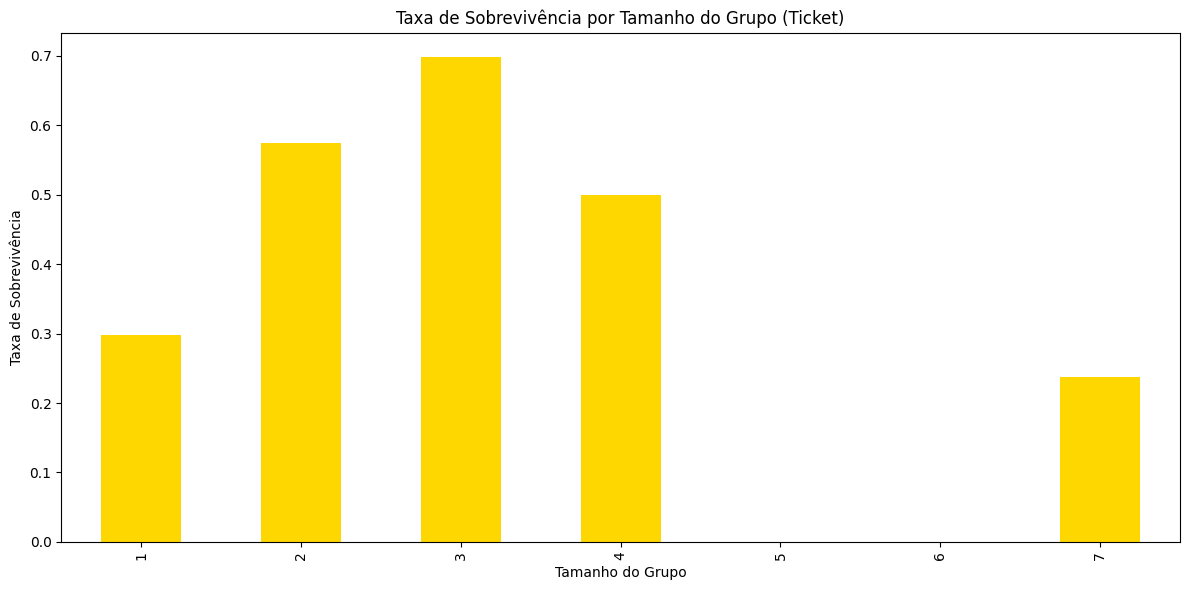

In [218]:
def extract_ticket_prefix(ticket):
    """Extrai prefixo do ticket"""
    if pd.isna(ticket):
        return 'Unknown'
    
    # Verificar se tem prefixo (letras)
    ticket = str(ticket).upper()
    prefix_match = re.match(r'([A-Z]+)', ticket)
    
    if prefix_match:
        return prefix_match.group(1)
    else:
        return 'Numeric'

# Aplicar extração de informações do ticket
df['Ticket_Prefix'] = df['Ticket'].apply(extract_ticket_prefix)

print(df['Ticket_Prefix'].value_counts().head(10))

# Verificar se existem tickets duplicados (famílias/grupos)
ticket_counts = df['Ticket'].value_counts()
df['Ticket_Group_Size'] = df['Ticket'].map(ticket_counts)

print(df['Ticket_Group_Size'].value_counts().head())

# Visualizar sobrevivência por tamanho do grupo
plt.figure(figsize=(12, 6))
survival_by_ticket_group = df.groupby('Ticket_Group_Size')['Survived'].mean()
survival_by_ticket_group.head(10).plot(kind='bar', color='gold')
plt.title('Taxa de Sobrevivência por Tamanho do Grupo (Ticket)')
plt.xlabel('Tamanho do Grupo')
plt.ylabel('Taxa de Sobrevivência')
plt.tight_layout()
plt.show()

In [219]:
# fill na in age
df['Age'] = df['Age'].fillna(df['Age'].median())

df['Age_Group'] = pd.cut(df['Age'], 
                        bins=[0, 12, 18, 35, 60, 100], 
                        labels=['Child', 'Teenager', 
                               'Young', 'Adult', 'Elderly'])


=== DISTRIBUIÇÃO POR GRUPO DE TARIFA ===
Fare_Group
High         229
Low          223
Very_High    222
Medium       217
Name: count, dtype: int64

=== TAXA DE SOBREVIVÊNCIA POR GRUPO DE TARIFA ===
Fare_Group
Very_High    0.581081
High         0.445415
Medium       0.308756
Low          0.197309
Name: Survived, dtype: float64


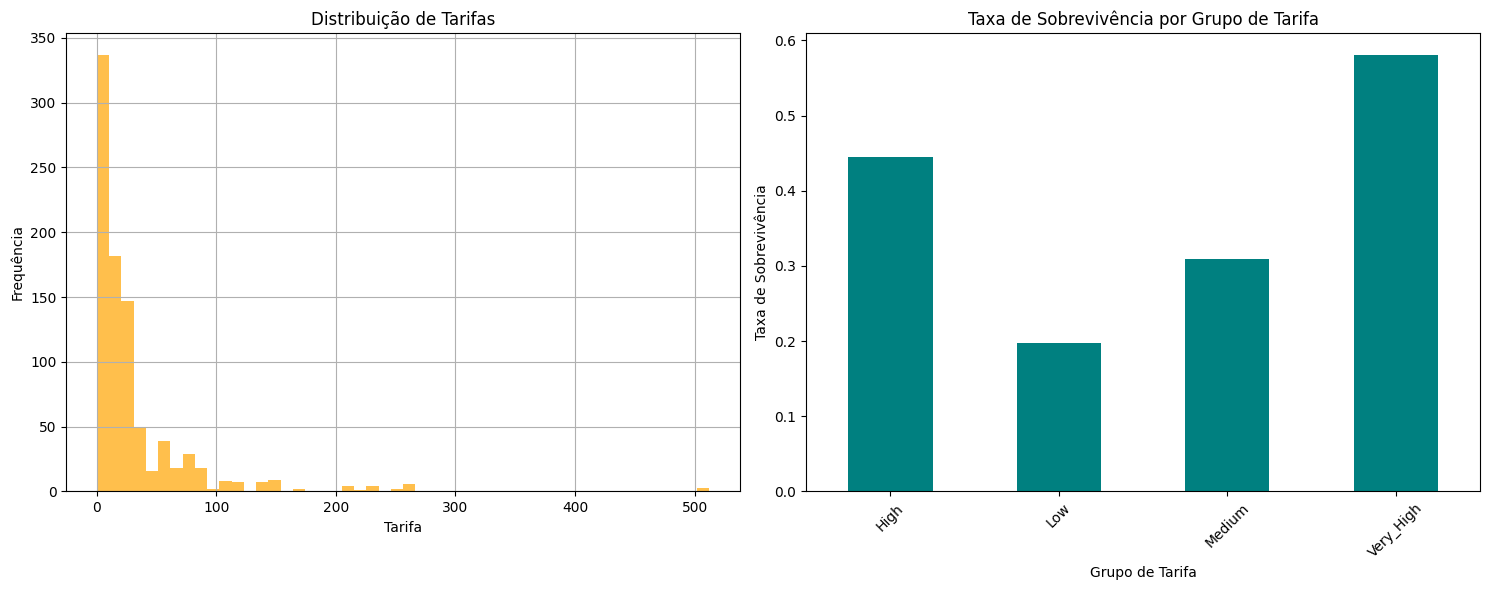

In [220]:
# Função para criar grupos de tarifa
def create_fare_groups(fare):
    """Cria grupos de tarifa baseados em quartis"""
    if pd.isna(fare):
        return 'Unknown'
    elif fare <= 7.91:
        return 'Low'
    elif fare <= 14.454:
        return 'Medium'
    elif fare <= 31:
        return 'High'
    else:
        return 'Very_High'

# Aplicar criação de grupos de tarifa
df['Fare_Group'] = df['Fare'].apply(create_fare_groups)

print("\n=== DISTRIBUIÇÃO POR GRUPO DE TARIFA ===")
print(df['Fare_Group'].value_counts())

# Taxa de sobrevivência por grupo de tarifa
survival_by_fare_group = df.groupby('Fare_Group')['Survived'].mean()
print("\n=== TAXA DE SOBREVIVÊNCIA POR GRUPO DE TARIFA ===")
print(survival_by_fare_group.sort_values(ascending=False))

# Visualização
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Distribuição de tarifas
df['Fare'].hist(bins=50, ax=axes[0], alpha=0.7, color='orange')
axes[0].set_title('Distribuição de Tarifas')
axes[0].set_xlabel('Tarifa')
axes[0].set_ylabel('Frequência')

# Sobrevivência por grupo de tarifa
survival_by_fare_group.plot(kind='bar', ax=axes[1], color='teal')
axes[1].set_title('Taxa de Sobrevivência por Grupo de Tarifa')
axes[1].set_xlabel('Grupo de Tarifa')
axes[1].set_ylabel('Taxa de Sobrevivência')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

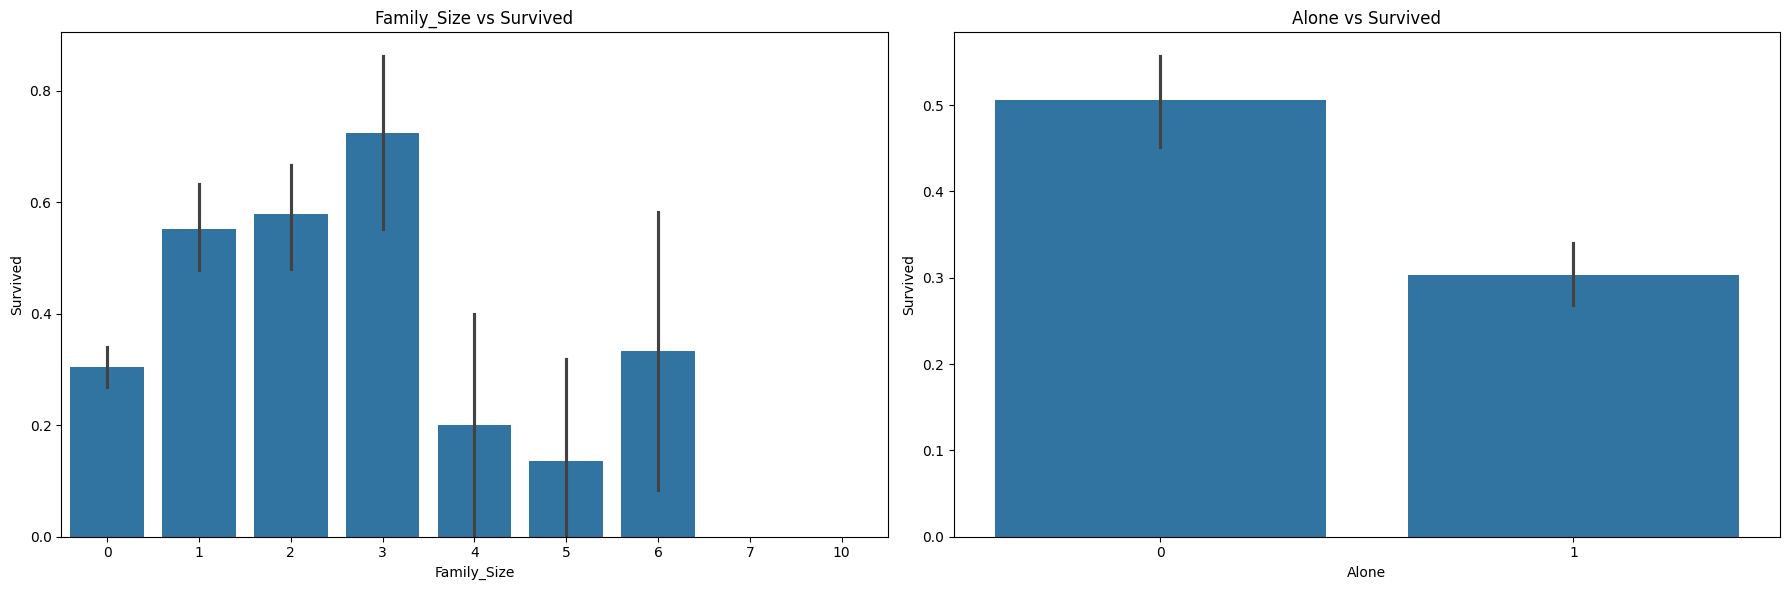

In [221]:
df['Family_Size'] = 0
df['Family_Size'] = df['Parch'] + df['SibSp']
df['Alone'] = 0
df.loc[df.Family_Size==0,'Alone'] = 1

f, ax = plt.subplots(1, 2, figsize=(18, 6))

sns.barplot(x='Family_Size', y='Survived', data=df, ax=ax[0])
ax[0].set_title('Family_Size vs Survived')

sns.barplot(x='Alone', y='Survived', data=df, ax=ax[1])
ax[1].set_title('Alone vs Survived')

plt.tight_layout()
plt.show()

In [222]:
# Imputar valores ausentes em Embarked com a moda
embarked_mode = df['Embarked'].mode()[0]
df['Embarked'] = df['Embarked'].fillna(embarked_mode)

In [223]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Title,Title_Mapped,Deck,Cabin_Count,Ticket_Prefix,Ticket_Group_Size,Age_Group,Fare_Group,Family_Size,Alone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,Mr,Mr,Unknown,0,A,1,Young,Low,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,Mrs,Mrs,C,1,PC,1,Adult,Very_High,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,Miss,Miss,Unknown,0,STON,1,Young,Medium,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,Mrs,Mrs,C,1,Numeric,2,Young,Very_High,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,Mr,Mr,Unknown,0,Numeric,1,Young,Medium,0,1


### Encoding

In [225]:
cat_ohe_cols = ['Embarked', 'Title_Mapped', 'Deck', 'Age_Group', 'Fare_Group', 'Ticket_Prefix']
binary_cols = ['Sex']  # será transformado com LabelEncoder via FunctionTransformer
ordinal_cat_features = ['Pclass', 'Alone']  # manteremos como estão

def label_encode_sex(X):
    return 1 if X == 'male' else 0

preprocessor = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), cat_ohe_cols),
    ('sex_le', FunctionTransformer(label_encode_sex, validate=True), binary_cols),
    ('passthrough', 'passthrough', ordinal_cat_features),
])

X = df[cat_ohe_cols + binary_cols + ordinal_cat_features]
preprocessor.fit(X)
X_encoded = preprocessor.transform(X)

ohe_columns = preprocessor.named_transformers_['ohe'].get_feature_names_out(cat_ohe_cols)
final_columns = list(ohe_columns) + ['Sex'] + ordinal_cat_features

df.drop(columns=(cat_ohe_cols + binary_cols + ordinal_cat_features), inplace=True)
df_encoded_part = pd.DataFrame(X_encoded, columns=final_columns, index=df.index)
df = pd.concat([df, df_encoded_part], axis=1)

cat_features = final_columns

print("=== VARIÁVEIS APÓS ONE-HOT ENCODING (ATUALIZANDO df DIRETAMENTE) ===")
print(f"Shape após encoding: {df.shape}")
print("\nNovas colunas criadas:")
print(cat_features[:20])

ValueError: could not convert string to float: 'male'

### Normalização e Padronização

In [ ]:
numerical_features = ['Family_Size', 'Cabin_Count', 'Ticket_Group_Size']

print("Estatísticas descritivas das variáveis numéricas antes de normalização:")
print(df[numerical_features].describe())

# Aplicar StandardScaler
df[numerical_features] = df[numerical_features].astype(float)
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

print("Estatísticas descritivas das variáveis numéricas antes de normalização:")
print(df[numerical_features].describe())

Estatísticas descritivas das variáveis numéricas antes de normalização:
       Family_Size  Cabin_Count  Ticket_Group_Size
count   891.000000   891.000000         891.000000
mean      0.904602     0.267116           1.787879
std       1.613459     0.547134           1.361142
min       0.000000     0.000000           1.000000
25%       0.000000     0.000000           1.000000
50%       0.000000     0.000000           1.000000
75%       1.000000     0.000000           2.000000
max      10.000000     4.000000           7.000000
Estatísticas descritivas das variáveis numéricas antes de normalização:
        Family_Size   Cabin_Count  Ticket_Group_Size
count  8.910000e+02  8.910000e+02       8.910000e+02
mean  -3.987333e-18 -4.984166e-17       6.180366e-17
std    1.000562e+00  1.000562e+00       1.000562e+00
min   -5.609748e-01 -4.884829e-01      -5.791618e-01
25%   -5.609748e-01 -4.884829e-01      -5.791618e-01
50%   -5.609748e-01 -4.884829e-01      -5.791618e-01
75%    5.915988e-02 -4.884

In [ ]:
features = cat_features + numerical_features
target = ['Survived']

# Exibir as primeiras linhas do DataFrame processado
df[features+target].iloc[:5]

,Deck_F,Ticket_Prefix_SW,Ticket_Prefix_PC,Ticket_Prefix_SO,Title_Mapped_Mrs,Ticket_Prefix_W,Embarked_Q,Title_Mapped_Rare,Deck_G,Ticket_Prefix_LINE,...,Ticket_Prefix_SCO,Ticket_Prefix_SOTON,Title_Mapped_Mr,Pclass,Sex,Alone,Family_Size,Cabin_Count,Ticket_Group_Size,Survived
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,3,1,0,0.059160,-0.488483,-0.579162,0
1,0,0,1,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0.059160,1.340249,-0.579162,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,3,0,1,-0.560975,-0.488483,-0.579162,1
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0.059160,1.340249,0.155928,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,3,1,1,-0.560975,-0.488483,-0.579162,0


# Modelagem

In [ ]:
features

['Deck_F',
 'Ticket_Prefix_SW',
 'Ticket_Prefix_PC',
 'Ticket_Prefix_SO',
 'Title_Mapped_Mrs',
 'Ticket_Prefix_W',
 'Embarked_Q',
 'Title_Mapped_Rare',
 'Deck_G',
 'Ticket_Prefix_LINE',
 'Age_Group_Young',
 'Ticket_Prefix_FA',
 'Fare_Group_Low',
 'Fare_Group_Medium',
 'Ticket_Prefix_PP',
 'Ticket_Prefix_CA',
 'Age_Group_Elderly',
 'Ticket_Prefix_Numeric',
 'Ticket_Prefix_WE',
 'Fare_Group_Very_High',
 'Age_Group_Teenager',
 'Deck_E',
 'Ticket_Prefix_F',
 'Ticket_Prefix_S',
 'Embarked_S',
 'Title_Mapped_Miss',
 'Deck_C',
 'Deck_D',
 'Deck_Unknown',
 'Ticket_Prefix_STON',
 'Age_Group_Adult',
 'Deck_T',
 'Ticket_Prefix_C',
 'Deck_B',
 'Ticket_Prefix_SC',
 'Ticket_Prefix_P',
 'Ticket_Prefix_SCO',
 'Ticket_Prefix_SOTON',
 'Title_Mapped_Mr',
 'Pclass',
 'Sex',
 'Alone',
 'Family_Size',
 'Cabin_Count',
 'Ticket_Group_Size']

In [ ]:
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Dicionário com os modelos para testar
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42, probability=True),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='logloss')
}

# Função para avaliar modelos
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Avalia um modelo e retorna métricas"""
    
    # Treinar modelo
    model.fit(X_train, y_train)
    
    # Predições
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    
    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1_Score': f1,
        'ROC_AUC': roc_auc
    }

# Avaliar todos os modelos
results = []

print("=== AVALIAÇÃO DE MODELOS BASELINE ===")
print("Treinando modelos...")

for name, model in models.items():
    print(f"Avaliando {name}...")
    
    # Usar dados padronizados para modelos que precisam
    if name in ['Logistic Regression', 'SVM', 'KNN']:
        result = evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test, name)
    else:
        result = evaluate_model(model, X_train, X_test, y_train, y_test, name)
    
    results.append(result)

# Criar DataFrame com resultados
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('F1_Score', ascending=False)

print("\n=== RESULTADOS DOS MODELOS BASELINE ===")
display(results_df.round(4))

=== AVALIAÇÃO DE MODELOS BASELINE ===
Treinando modelos...
Avaliando Logistic Regression...
Avaliando Random Forest...


c:\Users\vinic\Documents\GitHub\insider\titanic-model-deploy\venv\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\vinic\Documents\GitHub\insider\titanic-model-deploy\venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\vinic\Documents\GitHub\insider\titanic-model-deploy\venv\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Avaliando SVM...
Avaliando KNN...
Avaliando Naive Bayes...
Avaliando Decision Tree...
Avaliando Gradient Boosting...
Avaliando AdaBoost...


c:\Users\vinic\Documents\GitHub\insider\titanic-model-deploy\venv\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\vinic\Documents\GitHub\insider\titanic-model-deploy\venv\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\vinic\Documents\GitHub\insider\titanic-model-deploy\venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Avaliando XGBoost...


c:\Users\vinic\Documents\GitHub\insider\titanic-model-deploy\venv\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



=== RESULTADOS DOS MODELOS BASELINE ===


,Model,Accuracy,Precision,Recall,F1_Score,ROC_AUC
0,Logistic Regression,0.8156,0.7571,0.7681,0.7626,0.8505
7,AdaBoost,0.8156,0.7647,0.7536,0.7591,0.8501
2,SVM,0.7989,0.7538,0.7101,0.7313,0.8560
3,KNN,0.7989,0.7705,0.6812,0.7231,0.8343
1,Random Forest,0.7877,0.7313,0.7101,0.7206,0.8225
4,Naive Bayes,0.7430,0.6211,0.8551,0.7195,0.7742
6,Gradient Boosting,0.7821,0.7419,0.6667,0.7023,0.8487
8,XGBoost,0.7765,0.7458,0.6377,0.6875,0.8224
5,Decision Tree,0.7430,0.6769,0.6377,0.6567,0.7150


In [ ]:
assert 1==2

In [ ]:
# Definir grids de hiperparâmetros para os melhores modelos
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
}

# Selecionar top 3 modelos para otimização
top_3_models = cv_df.head(3)['Model'].tolist()
print("=== OTIMIZAÇÃO DE HIPERPARÂMETROS ===")
print("Modelos selecionados para otimização:", top_3_models)

# Função para grid search
def optimize_hyperparameters(model_name, model, param_grid, X_train, y_train, cv_folds):
    """Realiza grid search para otimizar hiperparâmetros"""
    
    print(f"\nOtimizando {model_name}...")
    print(f"Testando {np.prod([len(v) for v in param_grid.values()])} combinações...")
    
    # Grid Search
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv_folds,
        scoring='f1',
        n_jobs=-1,
        verbose=0
    )
    
    grid_search.fit(X_train, y_train)
    
    return {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'best_model': grid_search.best_estimator_
    }

# Realizar otimização para cada modelo selecionado
optimized_models = {}

for model_name in top_3_models:
    if model_name in param_grids:
        model = models[model_name]
        param_grid = param_grids[model_name]
        
        # Escolher dados adequados
        if model_name in ['Logistic Regression', 'SVM']:
            X_opt = X_train_scaled
        else:
            X_opt = X_train
        
        result = optimize_hyperparameters(model_name, model, param_grid, X_opt, y_train, cv)
        optimized_models[model_name] = result
        
        print(f"\n{model_name} - Melhor F1-Score: {result['best_score']:.4f}")
        print(f"Melhores parâmetros: {result['best_params']}")

print("\n=== RESUMO DA OTIMIZAÇÃO ===")
for model_name, result in optimized_models.items():
    print(f"{model_name}: F1-Score = {result['best_score']:.4f}")

=== OTIMIZAÇÃO DE HIPERPARÂMETROS ===
Modelos selecionados para otimização: ['Random Forest', 'AdaBoost', 'Logistic Regression']

Otimizando Random Forest...
Testando 108 combinações...


KeyboardInterrupt: 

# Seleção e Análise do Modelo Final

In [ ]:
# Selecionar o melhor modelo
best_model_name = comparison_df.iloc[0]['Model']
print(f"=== MELHOR MODELO: {best_model_name} ===")

# Obter o modelo treinado
if 'Optimized' in best_model_name:
    model_key = best_model_name.replace(' (Optimized)', '')
    best_model = optimized_models[model_key]['best_model']
    is_optimized = True
else:
    best_model = models[best_model_name]
    is_optimized = False

print(f"Modelo otimizado: {is_optimized}")

# Escolher dados adequados
if best_model_name.startswith(('Logistic', 'SVM')):
    X_train_final = X_train_scaled
    X_test_final = X_test_scaled
else:
    X_train_final = X_train
    X_test_final = X_test

# Retreinar se necessário
if not is_optimized:
    best_model.fit(X_train_final, y_train)

# Predições finais
y_pred_final = best_model.predict(X_test_final)
y_pred_proba_final = best_model.predict_proba(X_test_final)[:, 1] if hasattr(best_model, 'predict_proba') else None

print(f"\n=== MÉTRICAS FINAIS ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_final):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_final):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_final):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_final):.4f}")
if y_pred_proba_final is not None:
    print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_final):.4f}")

=== MELHOR MODELO: Logistic Regression ===
Modelo otimizado: False

=== MÉTRICAS FINAIS ===
Accuracy: 0.8156
Precision: 0.7571
Recall: 0.7681
F1-Score: 0.7626
ROC AUC: 0.8505


c:\Users\vinic\Documents\GitHub\insider\titanic-model-deploy\venv\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Matriz de confusão

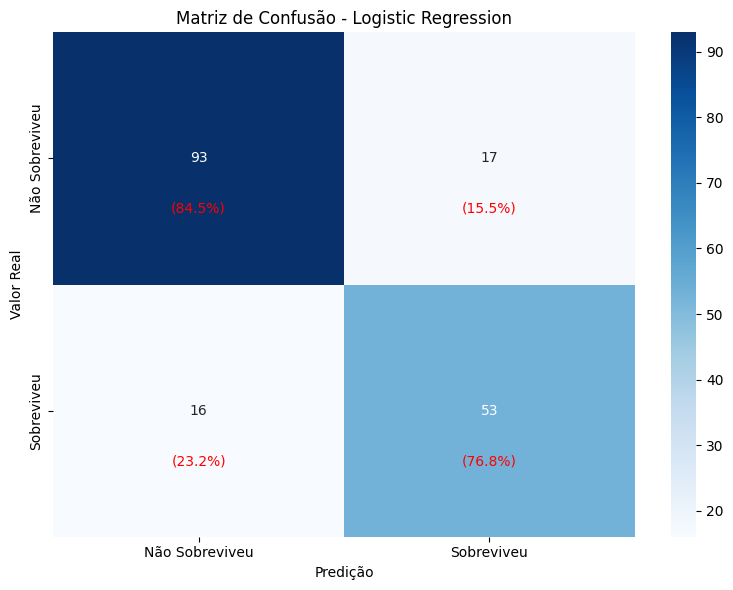


=== RELATÓRIO DE CLASSIFICAÇÃO ===
                precision    recall  f1-score   support

Não Sobreviveu       0.85      0.85      0.85       110
    Sobreviveu       0.76      0.77      0.76        69

      accuracy                           0.82       179
     macro avg       0.81      0.81      0.81       179
  weighted avg       0.82      0.82      0.82       179



In [ ]:
# Matriz de confusão
cm = confusion_matrix(y_test, y_pred_final)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Não Sobreviveu', 'Sobreviveu'],
            yticklabels=['Não Sobreviveu', 'Sobreviveu'])
plt.title(f'Matriz de Confusão - {best_model_name}')
plt.ylabel('Valor Real')
plt.xlabel('Predição')

# Adicionar percentuais
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j+0.5, i+0.7, f'({cm_percent[i, j]:.1%})', 
                ha='center', va='center', fontsize=10, color='red')

plt.tight_layout()
plt.show()

# Métricas detalhadas por classe
print(f"\n=== RELATÓRIO DE CLASSIFICAÇÃO ===")
print(classification_report(y_test, y_pred_final, 
                          target_names=['Não Sobreviveu', 'Sobreviveu']))

### Curva ROC

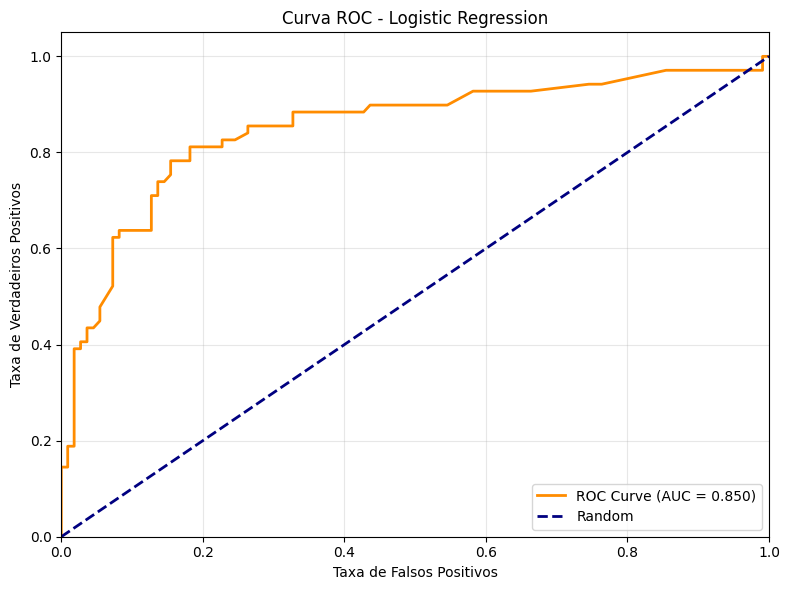

In [ ]:
if y_pred_proba_final is not None:
    # Calcular curva ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_final)
    roc_auc = roc_auc_score(y_test, y_pred_proba_final)
    
    # Plotar curva ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC Curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falsos Positivos')
    plt.ylabel('Taxa de Verdadeiros Positivos')
    plt.title(f'Curva ROC - {best_model_name}')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [ ]:
import pickle

model_filename = 'best_titanic_model.pkl'
with open(model_filename, 'wb') as model_file:
    pickle.dump(best_model, model_file)

# Testes

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class CategoricalFeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # Title
        X['Title'] = X['Name'].apply(lambda name: re.search(r' ([A-Za-z]+)\.', name).group(1)
                                     if re.search(r' ([A-Za-z]+)\.', name) else "")
        X['Title_Mapped'] = X['Title'].map({
            "Mr": "Mr", "Miss": "Miss", "Mrs": "Mrs", "Master": "Master",
            "Dr": "Rare", "Rev": "Rare", "Mlle": "Miss", "Major": "Rare",
            "Col": "Rare", "Sir": "Rare", "Mme": "Mrs", "Don": "Rare",
            "Lady": "Rare", "Countess": "Rare", "Jonkheer": "Rare",
            "Dona": "Rare", "Capt": "Rare"
        }).fillna("Rare")

        # Sex: binarizar
        X['Sex'] = X['Sex'].apply(lambda s: 1 if s == 'male' else 0)

        # Deck e Cabin_Count
        X['Deck'] = X['Cabin'].apply(lambda c: c[0] if pd.notna(c) else "Unknown")
        X['Cabin_Count'] = X['Cabin'].apply(lambda c: len(c.split()) if pd.notna(c) else 0)

        # Ticket_Prefix
        X['Ticket_Prefix'] = X['Ticket'].apply(
            lambda t: re.match(r'([A-Z]+)', str(t).upper()).group(1) if re.match(r'([A-Z]+)', str(t).upper()) else "Numeric"
        )

        # Age Group
        X['Age'] = X['Age'].fillna(X['Age'].median())
        X['Age_Group'] = pd.cut(X['Age'], bins=[0, 12, 18, 35, 60, 100],
                                labels=['Child', 'Teenager', 'Young', 'Adult', 'Elderly'])

        # Fare Group
        X['Fare_Group'] = X['Fare'].apply(lambda f: (
            'Low' if f <= 7.91 else
            'Medium' if f <= 14.454 else
            'High' if f <= 31 else
            'Very_High'
        ) if pd.notna(f) else 'Unknown')

        # Alone + Family_Size
        X['Family_Size'] = X['Parch'] + X['SibSp']
        X['Alone'] = (X['Family_Size'] == 0).astype(int)

        # Fill missing 'Embarked'
        X['Embarked'] = X['Embarked'].fillna(X['Embarked'].mode()[0])

        # Ticket_Group_Size (count dos bilhetes iguais)
        ticket_counts = X['Ticket'].value_counts()
        X['Ticket_Group_Size'] = X['Ticket'].map(ticket_counts)

        return X

In [ ]:
import numpy as np
import pandas as pd
import pickle
import logging
from typing import Dict, Any

logger = logging.getLogger('src.data_processing')

class TitanicPreprocessor:
    """Usa a pipeline treinada para preprocessar os dados"""

    def __init__(self, pipeline_path='./pipeline.pkl'):
        with open(pipeline_path, 'rb') as f:
            self.pipeline = pickle.load(f)

        # Recupera os nomes das colunas transformadas
        self.feature_names = self._get_feature_names()

    def _get_feature_names(self):
        """
        Extrai os nomes das features transformadas da pipeline.
        """
        try:
            column_transformer = self.pipeline.named_steps['preprocessing']
            ohe = column_transformer.named_transformers_['ohe']
            ohe_features = list(ohe.get_feature_names_out(column_transformer.transformers[0][2]))  # cat_ohe_cols

            passthrough_features = column_transformer.transformers[1][2]  # ordinal_cat_features
            numeric_features = ['Family_Size', 'Cabin_Count', 'Ticket_Group_Size']

            return ohe_features + passthrough_features + numeric_features

        except Exception as e:
            logger.warning(f"Não foi possível extrair nomes das features: {e}")
            return [f"feature_{i}" for i in range(self.pipeline.transform(
                pd.DataFrame([{
                    'PassengerId': 0, 'Pclass': 1, 'Name': '', 'Sex': 'male', 'Age': 30, 'SibSp': 0,
                    'Parch': 0, 'Ticket': '12345', 'Fare': 10.0, 'Cabin': None, 'Embarked': 'S'
                }])
            ).shape[1])]

    def process(self, data: Dict[str, Any]) -> Dict[str, Any]:
        """
        Processa os dados de entrada usando a pipeline salva e retorna como dicionário, incluindo PassengerId.
        """
        try:
            df_input = pd.DataFrame([data])
            transformed = self.pipeline.transform(df_input)
            df_transformed = pd.DataFrame(transformed, columns=self.feature_names)

            # Adiciona PassengerId de volta
            df_transformed.insert(0, 'PassengerId', df_input['PassengerId'].values)

            logger.info("Dados processados com sucesso pela pipeline.")
            return df_transformed.iloc[0].to_dict()

        except Exception as e:
            logger.error(f"Erro ao processar os dados com a pipeline: {e}")
            raise


In [ ]:
passenger_data = {
    'PassengerId': 1,
    'Pclass': 3,
    'Name': 'Kelly, Mr. James',
    'Sex': 'male',
    'Age': 34.5,
    'SibSp': 0,
    'Parch': 0,
    'Ticket': '330911',
    'Fare': 7.8292,
    'Cabin': None,
    'Embarked': 'Q'
}

preprocessor = TitanicPreprocessor(pipeline_path='./pipeline.pkl')
processed_data = preprocessor.process(passenger_data)

print("Dados processados com nomes reais:")
print(processed_data)


Dados processados com nomes reais:
{'PassengerId': 1.0, 'Embarked_Q': 1.0, 'Embarked_S': 0.0, 'Title_Mapped_Miss': 0.0, 'Title_Mapped_Mr': 1.0, 'Title_Mapped_Mrs': 0.0, 'Title_Mapped_Rare': 0.0, 'Deck_B': 0.0, 'Deck_C': 0.0, 'Deck_D': 0.0, 'Deck_E': 0.0, 'Deck_F': 0.0, 'Deck_G': 0.0, 'Deck_T': 0.0, 'Deck_Unknown': 1.0, 'Age_Group_Child': 0.0, 'Age_Group_Elderly': 0.0, 'Age_Group_Teenager': 0.0, 'Age_Group_Young': 1.0, 'Fare_Group_Low': 1.0, 'Fare_Group_Medium': 0.0, 'Fare_Group_Very_High': 0.0, 'Ticket_Prefix_C': 0.0, 'Ticket_Prefix_CA': 0.0, 'Ticket_Prefix_F': 0.0, 'Ticket_Prefix_FA': 0.0, 'Ticket_Prefix_LINE': 0.0, 'Ticket_Prefix_Numeric': 1.0, 'Ticket_Prefix_P': 0.0, 'Ticket_Prefix_PC': 0.0, 'Ticket_Prefix_PP': 0.0, 'Ticket_Prefix_S': 0.0, 'Ticket_Prefix_SC': 0.0, 'Ticket_Prefix_SCO': 0.0, 'Ticket_Prefix_SO': 0.0, 'Ticket_Prefix_SOTON': 0.0, 'Ticket_Prefix_STON': 0.0, 'Ticket_Prefix_SW': 0.0, 'Ticket_Prefix_W': 0.0, 'Ticket_Prefix_WE': 0.0, 'Pclass': 3.0, 'Alone': 1.0, 'Sex': 1.0, '

In [ ]:
import pickle
import numpy as np
import pandas as pd

class TitanicModel:
    def __init__(self, model_path='./model.pkl'):
        with open(model_path, 'rb') as f:
            self.model = pickle.load(f)

    def predict(self, data: dict) -> dict:
        """
        Realiza a predição usando o modelo carregado.
        
        Args:
            data (dict): dicionário com as features transformadas
        
        Returns:
            dict com 'prediction' e 'probability'
        """
        # Separa PassengerId (se presente) e transforma os dados em DataFrame
        passenger_id = data.get('PassengerId', None)
        data = {k: v for k, v in data.items() if k != 'PassengerId'}
        
        df = pd.DataFrame([data])
        
        # Garante a mesma ordem das colunas usadas no treinamento
        # expected_features = self.model.feature_names_in_
        # df = df.reindex(columns=expected_features, fill_value=0.0)

        # Realiza a predição
        prediction = self.model.predict(df)[0]
        probability = self.model.predict_proba(df)

        return {
            'passenger_id': passenger_id,
            'prediction': int(prediction),  # 0 ou 1
            'probability': probability
        }


model = TitanicModel(model_path='./model.pkl')
result = model.predict(processed_data)

print("Resultado da predição:", result)


Resultado da predição: {'passenger_id': 1.0, 'prediction': 0, 'probability': array([[0.90727497, 0.09272503]])}


c:\Users\vinic\Documents\GitHub\insider\titanic-model-deploy\venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\vinic\Documents\GitHub\insider\titanic-model-deploy\venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
